# Analizing shopping trends in Instacart

Instacart 2017 data set on orders is pretty extensive (713MB across 6 tables), including information about the products ordered, time of day and day of the week as well as categories for the different items.

The data can be downloaded from [Instacart dataset](https://www.instacart.com/datasets/grocery-shopping-2017) and includes training data of the orders made on 2017 as well as prior data about orders from the same (anonymized) users.

The data contains individual information of each order:
  * Products ordered,
  * User ID,
  * Time of day,
  * Day of the week,
  * Index of the order for the given user,
  * Days since last order.

It also contains, for each product, the following information:
  * Department (broad category)
  * Aisle (Fine category)
  * Has this item been ordered before by this user?

Analizing this information and deriving meaningful conclussions can lead to a better use of Instacart resources or benefit for their customers. For example, knowing when a product is more or less likely to be ordered can lead to sales and offers to customers to incentivize their purchase or drive it even higher.

## Loading data and libraries

In [39]:
library(dplyr)
library(repr)
library(ggplot2);

In [35]:
orders <- read.csv("instacart_2017_05_01//orders.csv")
products <- read.csv("instacart_2017_05_01//products.csv")
orders_prior <- read.csv("instacart_2017_05_01//order_products__prior.csv")
orders_train <- read.csv("instacart_2017_05_01//order_products__train.csv")

In [3]:
aisles <- read.csv("instacart_2017_05_01//aisles.csv")
departments <- read.csv("instacart_2017_05_01//departments.csv")

## How are purchases distributed in the week?

Looking at [Exploratory Analysis - Instacart](https://www.kaggle.com/philippsp/exploratory-analysis-instacart) one can see that orders are somewhat uniformly distributed per day of the week, with slightly more orders on Saturday and Sunday. However, once we look at what kind of products people buy on each day, that is not true anymore. We make the same assumption as in the mentioned article that days 0 and 1 represent Saturday and Sunday respectively.

For each individual product ordered (from `orders_prior`) we associate its `department` as well as the time of day and day of the week that it was purchased.

*Note: For all smoothing we use the method "loess" which is the default and recomended for low number of samples*

In [6]:
orders_prior_with_departments <- orders_train %>%
                        merge(products, by = "product_id") %>%
                        merge(orders, by = "order_id") %>%
                        merge(departments, by = "department_id") %>%
                        subset(select = c("department_id", "department", "order_dow", "order_hour_of_day"))

In [7]:
total_per_dept <- orders_prior_with_departments %>%
                  group_by(department_id) %>%
                  summarize(qty_tot = n())
orders_by_dow <- orders_prior_with_departments %>%
                    group_by(order_dow,department_id,department) %>%
                    summarize(qty = n()) %>%
                    merge(total_per_dept, by = "department_id", all.x = TRUE)

First, we show the general trend per day of the week, without discriminating per department (a similar plot can be found in the mentioned article). We can see that the trend is as described in the article, The average percentage per day is 14.29% (corresponding to the uniform distribution) but we can see that the orders are distributed with slightly more sales on the weekend.

The following plot shows the percentage of orders per day of the week and the smoothed trend. We will observe a similar trend in most of the departments.

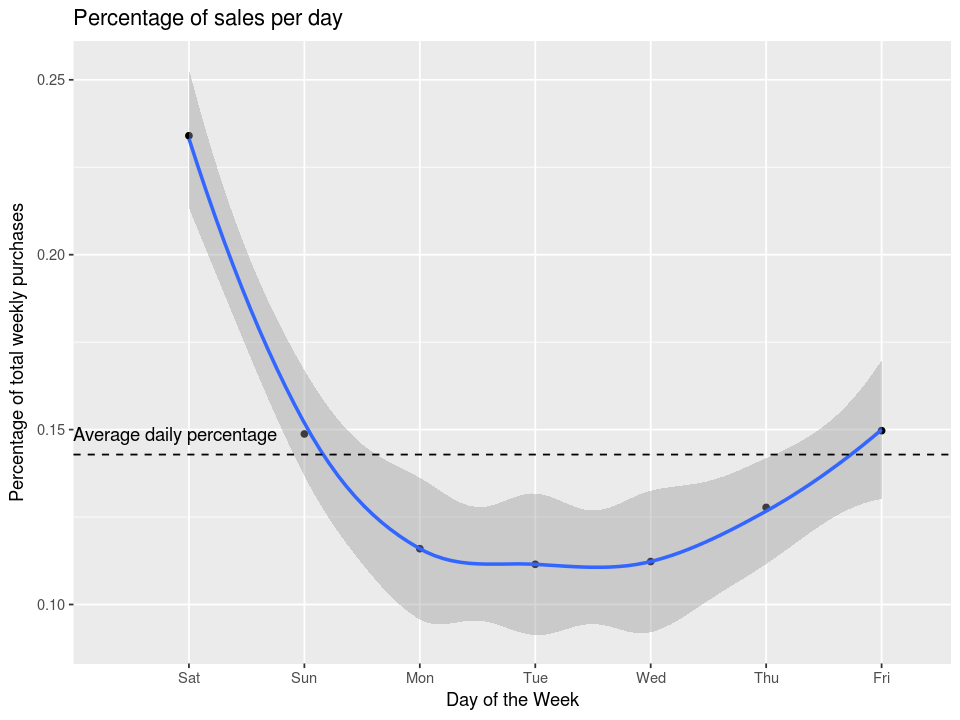

In [66]:
options(repr.plot.width=8, repr.plot.height=6)
orders_by_dow_total <- orders_by_dow %>%
                        group_by(order_dow) %>%
                        summarize(qty = sum(qty))
avg = mean(orders_by_dow_total$qty/total)
total = sum(orders_by_dow_total$qty)
ggplot(orders_by_dow_total, aes(y = qty/total)) + 
geom_point(aes(x = order_dow %>% factor(levels = c(0,1,2,3,4,5,6), 
                                    labels = c("Sat", "Sun", "Mon", "Tue", "Wed", "Thu", "Fri"), ordered=TRUE))) +
geom_smooth(method = "loess", aes(x = order_dow+1), level = 0.9) + 
labs(x = "Day of the Week", y = "Percentage of total weekly purchases") +
ggtitle("Percentage of sales per day") +
geom_hline(yintercept = avg,linetype="dashed")+
annotate("text", 0, avg, hjust = 0, vjust = -1, label = "Average daily percentage",)

The following plot shows, for each department (type of product) the percentage of those items that were ordered on each day of the week. 

We can see that for every department (except Alcohol), the trend is similar with higher purchases on the weekend and lower purchases in the middle of the week. However, for Alcohol the highest volume of purchases is done on the days preceding the weekend (Wednesday and Thursday).

We show the trends with an 0.8 confidence interval. We can see that the trend on non-alcoholic products is pretty reliable, as we have multiple data points that follow the same trend.

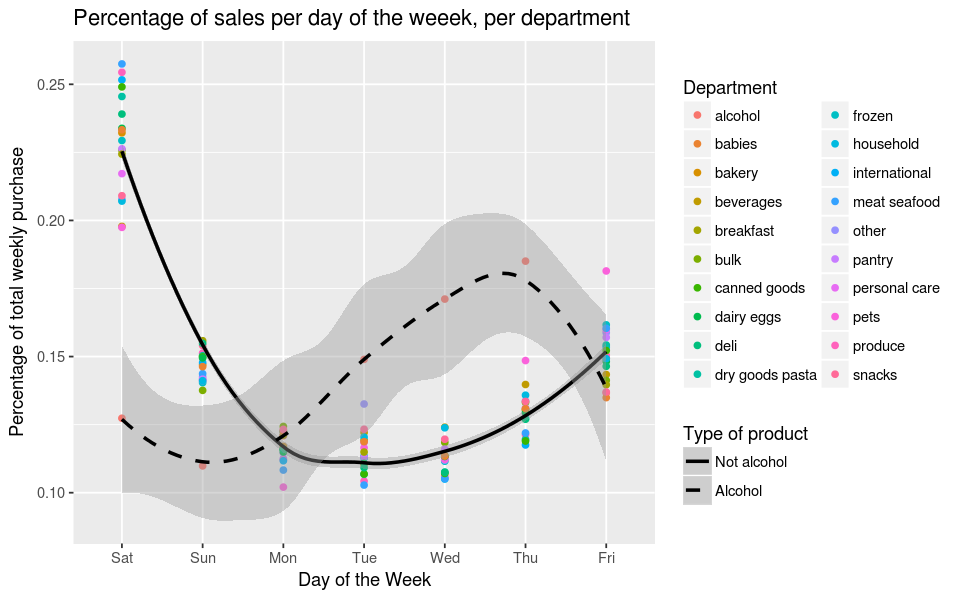

In [46]:
options(repr.plot.width=8, repr.plot.height=5)
ggplot(orders_by_dow %>% filter(department_id != 21) , 
       aes(
           y = qty/qty_tot, 
           )) + 
geom_point(aes(color = department,x = order_dow %>% factor(levels = c(0,1,2,3,4,5,6), 
                                    labels = c("Sat", "Sun", "Mon", "Tue", "Wed", "Thu", "Fri"), ordered=TRUE),
              group = factor(department == "alcohol", 
                                  levels = c(FALSE,TRUE), 
                                  labels=c("Not alcohol", "Alcohol")))) +
geom_smooth(method = "loess", aes(x = order_dow+1, 
                linetype = factor(department == "alcohol", 
                                  levels = c(FALSE,TRUE), 
                                  labels=c("Not alcohol", "Alcohol"))), 
            col = "black",
            level = 0.8) + 
labs(x = "Day of the Week", y = "Percentage of total weekly purchase", colour = "Department") +
ggtitle("Percentage of sales per day of the weeek, per department") +
scale_linetype_manual(name = "Type of product",values = c("solid","dashed"))+
guides(color = guide_legend(ncol=2))

One could think that the dissimilar trends are an artifact of splitting the purchases between Alcohol and Not alcohol. The following plots, which show the trends for each department show that this is not true. All departments except alcohol behave like the general trend observed above.

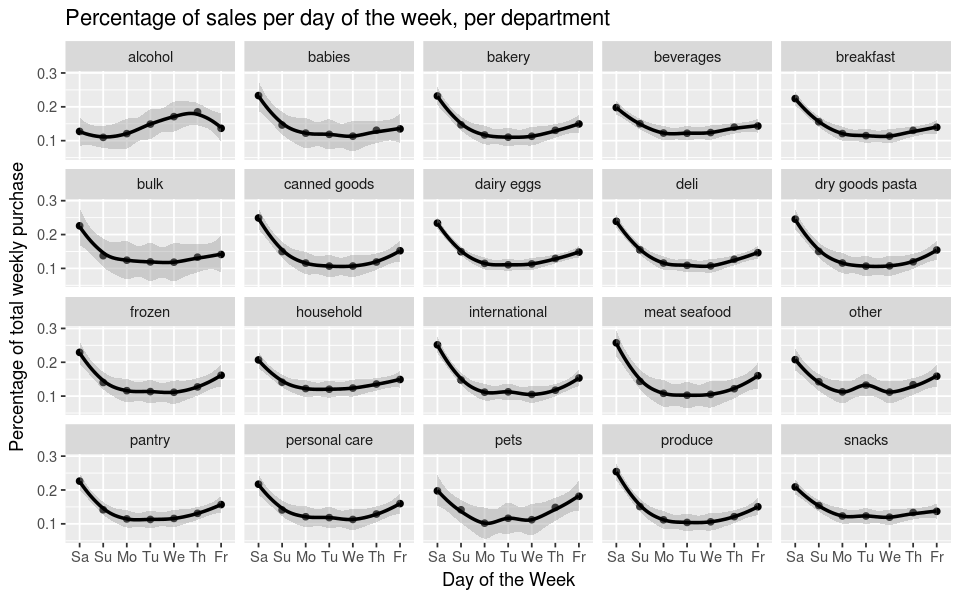

In [47]:
options(repr.plot.width=8, repr.plot.height=5)
ggplot(orders_by_dow %>% filter(department_id != 21) , 
       aes(
           y = qty/qty_tot, 
           )) + 
geom_point(aes(x = order_dow %>% factor(levels = c(0,1,2,3,4,5,6), 
                                    labels = c("Sa", "Su", "Mo", "Tu", "We", "Th", "Fr"), ordered=TRUE))) +
facet_wrap(~department)+
geom_smooth(method = "loess", aes(x = order_dow+1), 
            col = "black",
            level = 0.9) + 
labs(x = "Day of the Week", y = "Percentage of total weekly purchase", colour = "Department") +
ggtitle("Percentage of sales per day of the week, per department") +
scale_linetype_manual(name = "Type of product",values = c("solid","dashed"))

# References

* “The Instacart Online Grocery Shopping Dataset 2017”, Accessed from [https://www.instacart.com/datasets/grocery-shopping-2017](https://www.instacart.com/datasets/grocery-shopping-2017) on 10/28/2017
* *Spachtholz, P.*. "Exploratory Analysis - Instacart". Accessed from [https://www.kaggle.com/philippsp/exploratory-analysis-instacart](https://www.kaggle.com/philippsp/exploratory-analysis-instacart) on 10/29/2017. 